## Import libraries

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import librosa.display
from itertools import cycle
import IPython.display as ipd
import matplotlib.pylab as plt


sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Load data

In [5]:
# Load all audio data path
# The data file path should be like: './Data/user/user.wav'
# The label should be like: 'user'

audio_files = glob('./Data/*.mp3')

audio_files
# Get the labels of each file:
labels = []
for file in audio_files:
    labels.append(file.split('/')[-1].split('.')[0]) # suppose we have paths like: './Data/user/user.wav'

labels

['Lin', 'Maria', 'Martin']

In [6]:
# Demonstrate audio sample
ipd.Audio(audio_files[0]) # Now there is no file

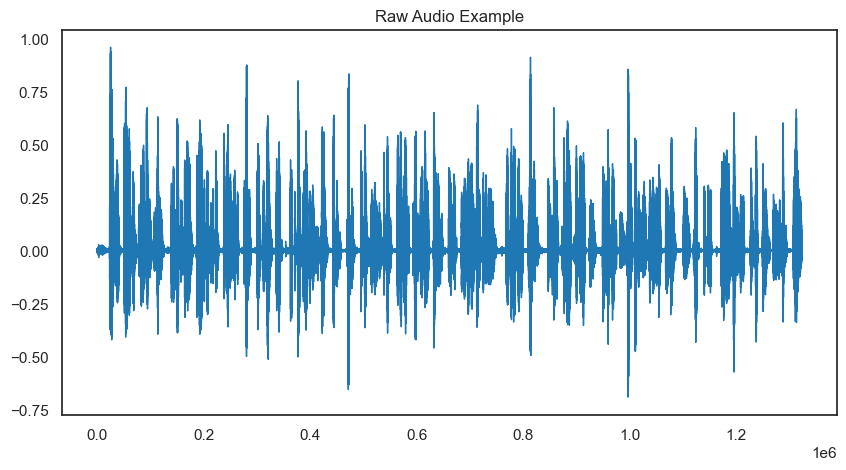

In [7]:
# Illustration of audio sample in the wave form
# When there is/are audio file in the Data, run this code
y, sr = librosa.load(audio_files[0])

pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  color=color_pal[0])
plt.show()

## Preprocessing data

Transform data into Mel Spectogram

In [8]:
S = librosa.feature.melspectrogram(y=y, # data to convert to melspectrogram data
                                   sr=sr, # sampling rate
                                   n_mels=128 * 2)

S_db_mel = librosa.amplitude_to_db(S, # Data to get the amplitudes
                                   ref=np.max)

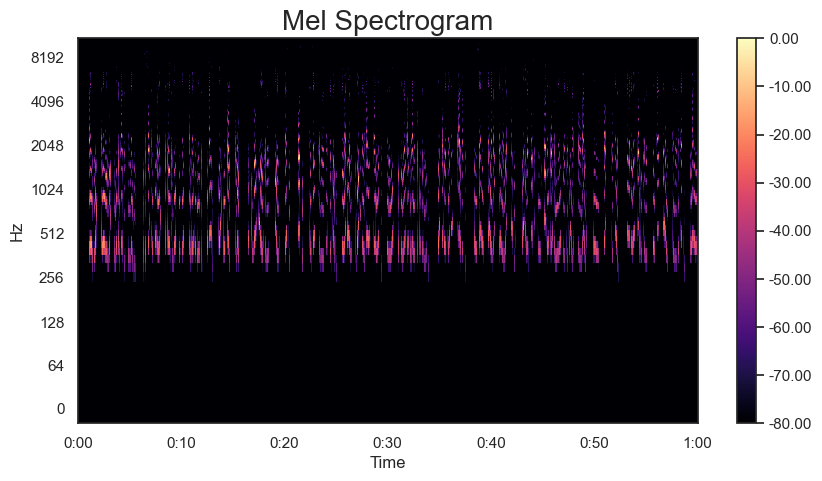

In [9]:
# Illustrate the Mel Spectrogram

fig, ax = plt.subplots(figsize=(10, 5))

img = librosa.display.specshow(S_db_mel, # Data set to draw mel spectogram
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Mel Spectrogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%.2f')

### Preprocess data to Mel-frequency Cepstral Coefficients data representation

In [53]:
# audio_sample, sr = librosa.load('./Data/Lin.mp3')
# partitions = audio_sample.shape[0] // (sr * 3)
# sr_sliced = sr * 3

def slice_audio(audio, partitions, sr_scaled):
    my_list = [None]*partitions

    for i in range(partitions):
        my_list[i] = audio[i*sr_scaled:(i+1)*sr_scaled]

    return np.array(my_list)

def mel_freq(data_dir='./Data/'):
    features = []
    labels = []
    
    for audio_file in os.listdir(data_dir)[1:]:
        label = audio_file.split('.')[0]
        file_path = os.path.join(data_dir, audio_file)
        # Load the audio file
        audio, sr = librosa.load(file_path)
        partitions = audio.shape[0] // (sr * 3)
        sr_sliced = sr * 3
                
        audios = slice_audio(audio,
                            partitions=partitions,
                            sr_scaled=sr_sliced)

        for aud in audios:
            # Extract MFCC features
            mfcc = librosa.feature.mfcc(y=aud,
                                        sr=sr,
                                        n_mfcc=13,
                                        hop_length=512,
                                        n_mels=26)
            # Append the features and label to the lists
            features.append(mfcc)
            labels.append(label)
    return np.array(features), np.array(labels)

In [54]:
def get_mel_data():
    features, labels = mel_freq()

    num_samples = features.shape[0]
    num_mfcc = features[0].shape[0]
    num_frames = features[0].shape[1]

    features_2d = np.reshape(features, (num_samples, num_frames * num_mfcc))
    label_map = {'Lin': 0, 'Maria': 1, 'Martin': 2} # rename the keys
    labels = [label_map[x] for x in labels]
    
    return features_2d, labels

features_2d, labels = get_mel_data()

In [57]:
# Split the data
from sympy.abc import y
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(features_2d, labels, test_size=0.2, random_state=42)

## Build model

In [59]:
# Random forest classifer model
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500,
                             criterion='log_loss',
                             max_depth=4,
                             min_samples_split=.2,
                             min_samples_leaf=2)


In [60]:
# Train the model
rfc.fit(Xtrain, ytrain)

RandomForestClassifier(criterion='log_loss', max_depth=4, min_samples_leaf=2,
                       min_samples_split=0.2, n_estimators=500)

In [61]:
# Evaluate the model performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
y_pred = rfc.predict(Xtest)
print(classification_report(ytest, y_pred))
print(confusion_matrix(ytest, y_pred))
print(accuracy_score(ytest, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[4 0 0]
 [0 2 0]
 [0 0 6]]
1.0
